In [43]:
# add src to path
import sys, os; sys.path.append(os.path.abspath(".."))

import pandas as pd
from src.features import add_basic_features, add_interactions, add_ratios
from src.build_matrix import build_design_matrices
from src.io_utils import save_parquet, save_pickle, save_json
from src.config import CAP_COLS

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from joblib import parallel_backend

# 0) Load raw
Ames = pd.read_csv("../data/raw/ames.csv", index_col=0)

# 1) Feature engineering
X_fe = add_basic_features(Ames)
X_fe = add_interactions(X_fe)
X_fe = add_ratios(X_fe)

# 2) Build matrices (with fold-safe capping applied to selected numeric columns)
transformed_df, X_final, pre = build_design_matrices(
    X_fe, numeric_cap=CAP_COLS, lower_q=0.01, upper_q=0.99
)

# 3) Save artifacts
save_parquet(transformed_df, "../data/interim/transformed_df.parquet")   # X_raw for trees
# save_parquet(X_final,        "../data/interim/X_final.parquet")
save_parquet(Ames[["SalePrice"]], "../data/interim/target.parquet")
save_parquet(X_fe, "../data/interim/X_fe.parquet")

# Save preprocessor & names for inference
save_pickle(pre, "../models/preprocessor.pkl")
save_json(list(transformed_df.columns), "../models/feature_names.json")

In [21]:
pd.set_option('display.max_columns', None)
transformed_df

,Electrical,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath,LotArea,LotFrontage,MasVnrArea,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,GrLivArea_per_LotArea,OverallQual,OverallCond,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalBaths,HouseAge,HouseAgeSinceRemod,GarageAge,GrLivArea_x_Qual,TotalSF_x_Qual,Baths_x_Garage,Age_x_Qual,AgeRemod_x_Qual,Baths_per_Bed,GrLiv_per_Room,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLa

In [22]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1) 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = {'n_estimators': range(30, 110, 30), 'max_depth': range(3, 20, 2)}
gs = GridSearchCV(rf, grid, cv=cv, n_jobs=4, scoring='neg_root_mean_squared_error', return_train_score=True)

with parallel_backend('threading'):
    results = gs.fit(transformed_df, Ames.SalePrice)

ans = pd.DataFrame(results.cv_results_)

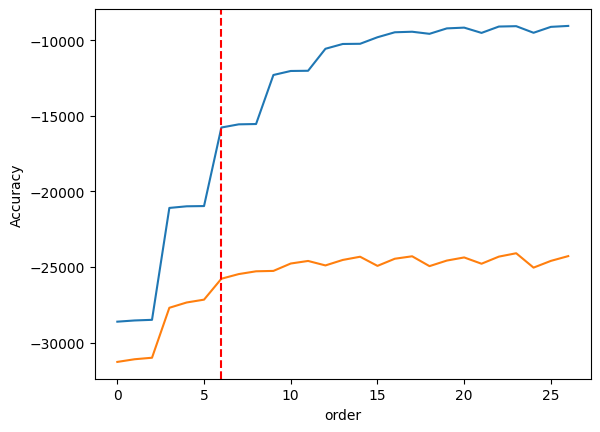

In [23]:
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=6,linestyle='--', color='r')
plt.show()

In [9]:
ans['params'][6]

{'max_depth': 7, 'n_estimators': 30}

In [26]:
rf.set_params(max_depth=7, n_estimators=30)
rf.fit(transformed_df, Ames.SalePrice)

,n_estimators,30
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


TotalSF_x_Qual        0.881592
Baths_x_Garage        0.015180
BsmtUnfSF             0.007073
HouseAgeSinceRemod    0.006395
LotArea               0.006179
GrLivArea_x_Qual      0.005983
AgeRemod_x_Qual       0.004741
GrLiv_per_Room        0.003479
Baths_per_Bed         0.003426
GarageArea            0.002837
dtype: float64

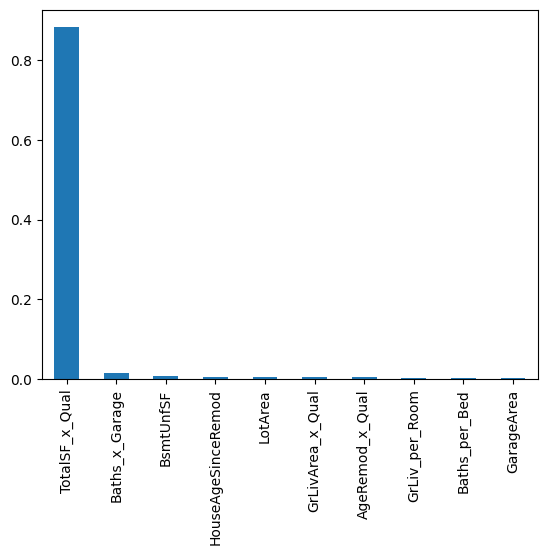

In [27]:
model_importance = pd.Series(rf.feature_importances_, index=transformed_df.columns).sort_values(ascending=False)

display(model_importance.head(10))
model_importance.head(10).plot(kind="bar")
plt.show()

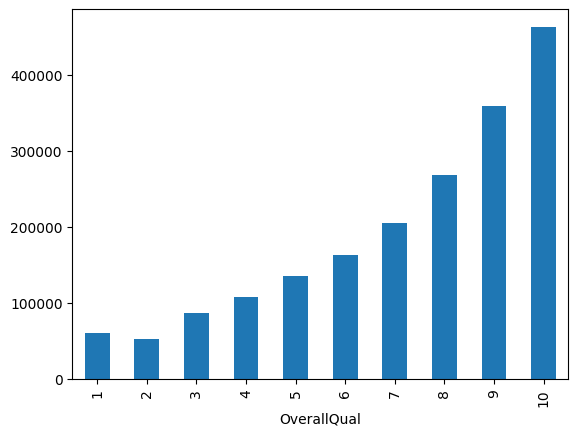

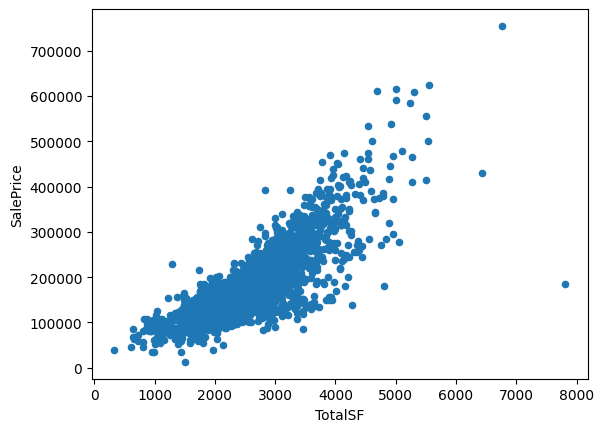

In [12]:
Ames.groupby(model_importance.index[0])['SalePrice'].mean().plot(kind="bar")

pd.concat([X_fe, target], axis = 1)[[model_importance.index[1], 'SalePrice']].plot(
    kind='scatter', x=model_importance.index[1], y='SalePrice')

plt.show()

In [31]:
X['GrLivArea_per_LotArea']

1      0.108478
2      0.247639
3      0.165154
4      0.127532
5      0.198191
         ...   
759    0.107510
760    0.126672
761    0.319247
762    0.208678
763    0.200000
Name: GrLivArea_per_LotArea, Length: 2580, dtype: float64

In [41]:
X = transformed_df.copy()

# ---- 1. Define which numeric columns to log-transform ----
log_cols = [
    "LotArea", "LotFrontage", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
    "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "TotalSF", "GrLivArea_per_LotArea"
]

# Keep only columns that actually exist in X
log_cols = [c for c in log_cols if c in X.columns]

# ---- 2. Define full numeric scaling list ----
scale_features = [
    # Continuous
    "GrLivArea", "LotFrontage", "LotArea", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GarageArea",
    "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch",
    "ScreenPorch", "PoolArea", "MiscVal", "TotalSF", "GrLivArea_per_LotArea",

    # Counts
    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
    "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
    "Fireplaces", "GarageCars", "TotalBaths",

    # Ordinal-as-numeric
    "OverallQual", "OverallCond",

    # Year variables (or replace with "age")
    "YearBuilt",
    "YearRemodAdd",
    "GarageYrBlt",
    "HouseAge",
    "HouseAgeSinceRemod",
    "GarageAge"
]

scale_features = [c for c in scale_features if c in X.columns]

# ---- 3. Apply log transform first, then scale ----
X_num = X[scale_features].copy()
X_num[log_cols] = X_num[log_cols].apply(np.log1p)

scaler = StandardScaler()
X_scaled_num = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=scale_features,
    index=X.index
)

# ---- 4. Combine back with one-hot columns ----
onehot_cols = [c for c in X.columns if c not in scale_features]
X_final = pd.concat([X_scaled_num, X[onehot_cols]], axis=1)

target_scaled = np.log1p(Ames.SalePrice)

save_parquet(X_final,        "../data/interim/X_final.parquet")